- Intructions on this Repo
1. Heap size error run this command line before run jupyter notebook on command line

export PYSPARK_SUBMIT_ARGS=' --conf spark.sql.shuffle.partitions=700 --conf spark.default.parallelism=700 --driver-memory 30g --driver-cores 6 --executor-memory 30g --executor-cores 6 pyspark-shell'

2. ERROR PythonRunner: Python worker exited unexpectedly (crashed) java.net.SocketException: Connection reset

Try to run several times

## Demand Forecasting

The objective of this notebook is to illuate how we might leverage the Apache Spark - the efficient distribution of the work required to generate hundreds of thousands or even millions of ML models in a timely manner and FBProphet - popular library for demanding forecasting.

NOTE: The original notebook utilized the DataBricks and DataLakes. In this notebook, I will use my Spark SQL and localhost storage to emulate the orginal notebook 

### Exploring Data
- Source: https://www.kaggle.com/competitions/demand-forecasting-kernels-only/data

A relatively simple and clean dataset, given 5 years of store-item sales data(10 stores), and asked to predict 3 months of sales for 50 different items at 10 different stores. 

What's the best way to deal with seasonality? Should stores be modeled separately, or can you pool them together? 



#### Import Data from local to sql database
- use pyspark to import data to sql database, to work similarly to DataBricks notebook

In [1]:
#libraries
import pandas as pd
import numpy as np

#### Create SQL databse using Pyspark


In [2]:
#libraries
import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, SQLContext
print(f"Pyspark Version: {pyspark.__version__}")

Pyspark Version: 3.3.0


In [3]:
#Create a spark Context class
sc = SparkContext()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/02/22 22:59:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [62]:
from delta import *

ModuleNotFoundError: No module named 'delta'

In [4]:
#Create spark session
spark = SparkSession.builder.master('local[*]').\
            config('spark.sql.debug.maxToStringFields', '100').\
            appName("Time Serries Forecasting").getOrCreate()

In [5]:
#read the training data into a dataframe, and convert to datatype accordingly
#library
from pyspark.sql.types import *

#structure of the training dataset
train_schema = StructType([
    StructField('date', DateType()),
    StructField('store', IntegerType()),
    StructField('item', IntegerType()),
    StructField('sales', IntegerType())
])

spdf_data = spark.read.csv('./Data/train.csv', header=True, schema=train_schema)

In [6]:
spdf_data.printSchema()

root
 |-- date: date (nullable = true)
 |-- store: integer (nullable = true)
 |-- item: integer (nullable = true)
 |-- sales: integer (nullable = true)



In [7]:
#make the temporary view table
spdf_data.createOrReplaceTempView('train')

In [8]:
##load sparksql magic to run sql queries in notebook cell
%load_ext sparksql_magic

In [9]:
%%sparksql
SELECT * FROM train;

only showing top 20 row(s)


date,store,item,sales
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
2013-01-06,1,1,12
2013-01-07,1,1,10
2013-01-08,1,1,9
2013-01-09,1,1,12
2013-01-10,1,1,9


##### General annual trends and seasonality in unit sales
NOTE: DataBricks sql is able to visuallize immediately with sql queries in notebook cells, on Jupyter notebook we will create dataframe and visuallize using python visuallize libraries

##### Plot the annual trending 

In [10]:
%%sparksql
SELECT year(date) as year,
        sum(sales) as sales 
    FROM train 
    GROUP BY year(date) 
    ORDER BY year;

year,sales
2013,7941243
2014,9135482
2015,9536887
2016,10357160
2017,10733740


In [11]:
#collect data
query_annual_trending ='\
    SELECT year(date) as year,\
            sum(sales) as sales \
    FROM train \
    GROUP BY year(date) \
    ORDER BY year;'
collected_annual_trending = spark.sql(query_annual_trending).collect()

In [12]:
collected_annual_trending

[Row(year=2013, sales=7941243),
 Row(year=2014, sales=9135482),
 Row(year=2015, sales=9536887),
 Row(year=2016, sales=10357160),
 Row(year=2017, sales=10733740)]

In [13]:
#convert to dataframe for plotting
df_annual_trending = pd.DataFrame(collected_annual_trending, columns=['year', 'million_sales'])
df_annual_trending['million_sales'] = df_annual_trending['million_sales'].apply(lambda x: x/10**6)

In [14]:
df_annual_trending

,year,million_sales
0,2013,7.941243
1,2014,9.135482
2,2015,9.536887
3,2016,10.357160
4,2017,10.733740


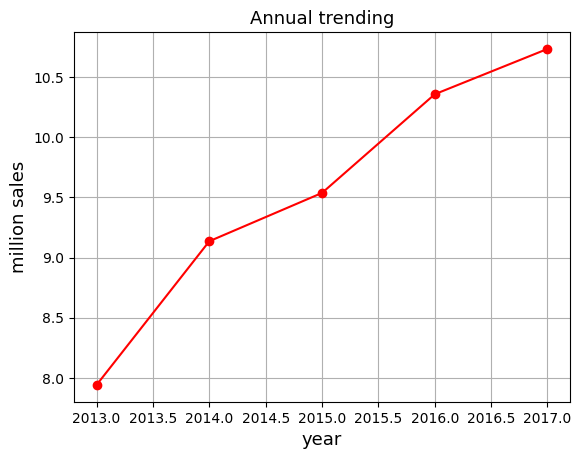

In [15]:
#plot
import matplotlib.pyplot as plt

plt.plot(df_annual_trending['year'], df_annual_trending['million_sales'], color='red', marker='o')
plt.title("Annual trending", fontsize=13)
plt.xlabel('year', fontsize=13)
plt.ylabel('million sales', fontsize=13)
plt.grid(True)
plt.show()

It is very clear growth from our annual trending chart in total sales across the stores. From this trend, we are able to expect our warehouse capacity to increase, and We might expect continued growth in few days, months.

##### Plotting Seasonality trend

In [16]:
%%sparksql
SELECT
    TRUNC(date, 'MM') as month,
    SUM(sales) as sales
FROM train
GROUP BY TRUNC(date, 'MM')
ORDER BY month;

only showing top 20 row(s)


month,sales
2013-01-01,454904
2013-02-01,459417
2013-03-01,617382
2013-04-01,682274
2013-05-01,763242
2013-06-01,795597
2013-07-01,855922
2013-08-01,766761
2013-09-01,689907
2013-10-01,656587


In [17]:
#collect data
query_seasonality_trending ="\
    SELECT TRUNC(date, 'MM') as month,\
            sum(sales) as sales \
    FROM train \
    GROUP BY TRUNC(date, 'MM') \
    ORDER BY month;"
collected_seasonality_trending = spark.sql(query_seasonality_trending).collect()

In [18]:
collected_seasonality_trending[0:10]

[Row(month=datetime.date(2013, 1, 1), sales=454904),
 Row(month=datetime.date(2013, 2, 1), sales=459417),
 Row(month=datetime.date(2013, 3, 1), sales=617382),
 Row(month=datetime.date(2013, 4, 1), sales=682274),
 Row(month=datetime.date(2013, 5, 1), sales=763242),
 Row(month=datetime.date(2013, 6, 1), sales=795597),
 Row(month=datetime.date(2013, 7, 1), sales=855922),
 Row(month=datetime.date(2013, 8, 1), sales=766761),
 Row(month=datetime.date(2013, 9, 1), sales=689907),
 Row(month=datetime.date(2013, 10, 1), sales=656587)]

In [19]:
#convert to dataframe for plotting
df_seasonality_trending = pd.DataFrame(collected_seasonality_trending, columns=['month', 'thousand_sales'])
df_seasonality_trending['thousand_sales'] = df_seasonality_trending['thousand_sales'].apply(lambda x: x/1000)

<IPython.core.display.Javascript object>


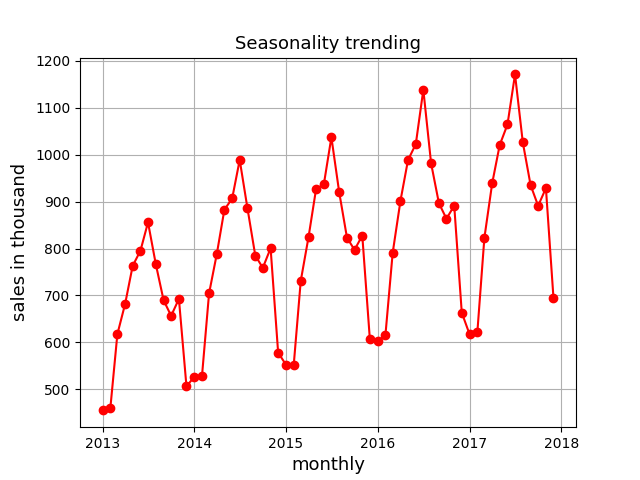

In [20]:
#simple plot
import matplotlib.pyplot as plt
%matplotlib notebook
##
plt.plot(df_seasonality_trending['month'], df_seasonality_trending['thousand_sales'], color='red', marker='o')
plt.title('Seasonality trending', fontsize=13)
plt.xlabel('monthly', fontsize=13)
plt.ylabel('sales in thousand', fontsize=13)
plt.grid(True)

plt.show()

<IPython.core.display.Javascript object>


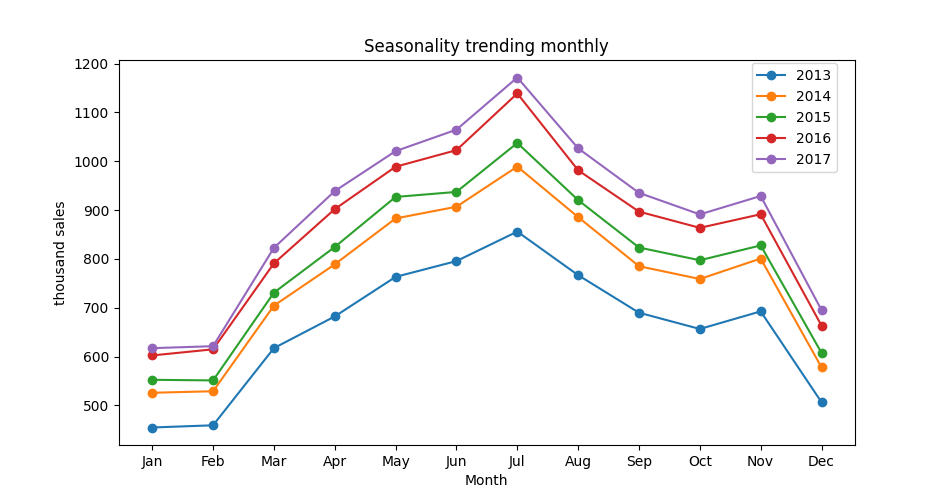

In [21]:
#seasonality trending in each year
#libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import datetime

df_plotting = df_seasonality_trending.copy() #stop cause error when editing on same df
df_plotting['month'] = pd.to_datetime(df_plotting['month'])
df_plotting.set_index('month', inplace=True)

pt_df_plotting = pd.pivot_table(df_plotting,
                    index=df_plotting.index.month,
                    columns=df_plotting.index.year)
pt_df_plotting.columns = pt_df_plotting.columns.droplevel() # remove the double header (0) as pivot creates a multiindex.

ax = plt.figure(figsize=(9.5,5)).add_subplot()
ax.plot(pt_df_plotting, marker='o')
ax.set_xlabel("Month")
ax.set_ylabel('thousand sales')

ticklabels = [datetime.date(2023, item, 1).strftime('%b') for item in pt_df_plotting.index] #get month label in string format
ax.set_xticks(np.arange(1,13))
ax.set_xticklabels(ticklabels) #add monthlabels to the xaxis
ax.set_title('Seasonality trending monthly')
#ax.xaxis("New")
ax.legend(pt_df_plotting.columns.tolist(), loc='center left', bbox_to_anchor=(0.85, .85)) #add the column names as legend.

plt.show()

We sees that monthly parttern is increasing from Feb, peak on Jun and start to going down on Dec. This pattern is stable from year 2013 to year 2017

##### Plotting the weakly seasonality trending

0 = Monday, 1 = Tuesday, 2 = Wednesday, 3 = Thursday, 4 = Friday, 5 = Saturday, 6 = Sunday

In [22]:
%%sparksql
SELECT YEAR(date) as year, WEEKDAY(date) as weekday, AVG(sales) as avg_sales
FROM (SELECT date, SUM(sales) as sales
      FROM train
      GROUP BY date
      ORDER BY date)
GROUP BY year, weekday
ORDER BY year, weekday;

only showing top 20 row(s)


year,weekday,avg_sales
2013,0,17269.69230769231
2013,1,20015.811320754718
2013,2,20150.153846153848
2013,3,21503.19230769231
2013,4,23071.096153846152
2013,5,24532.903846153848
2013,6,25788.44230769231
2014,0,19791.98076923077
2014,1,23179.346153846152
2014,2,23009.471698113208


In [23]:
#collect data to convert to dataframe
query_weekday_seasonality_trending ='''\
SELECT YEAR(date) as year, WEEKDAY(date) as weekday, AVG(sales) as avg_sales \
FROM (SELECT date, SUM(sales) as sales \
        FROM train \
        GROUP BY date) \
GROUP BY year, weekday \
ORDER BY year, weekday;'''

#collected_weekday_seasonality_trending = spark.sql(query_weekday_seasonality_trending).toPandas()

#map weekday
map_weekday = {0: "Monday", 1: "Tuesday", 2: "Wednesday",
               3: "Thursday", 4: "Friday", 5: "Saturday", 6: "Sunday"}
#convert to dataframe for plotting
df_weekday_seasonality_trending = spark.sql(query_weekday_seasonality_trending).toPandas()
df_weekday_seasonality_trending['weekday'] = df_weekday_seasonality_trending['weekday'].map(map_weekday)

In [24]:
df_weekday_seasonality_trending.head(5)

,year,weekday,avg_sales
0,2013,Monday,17269.692308
1,2013,Tuesday,20015.811321
2,2013,Wednesday,20150.153846
3,2013,Thursday,21503.192308
4,2013,Friday,23071.096154


<IPython.core.display.Javascript object>


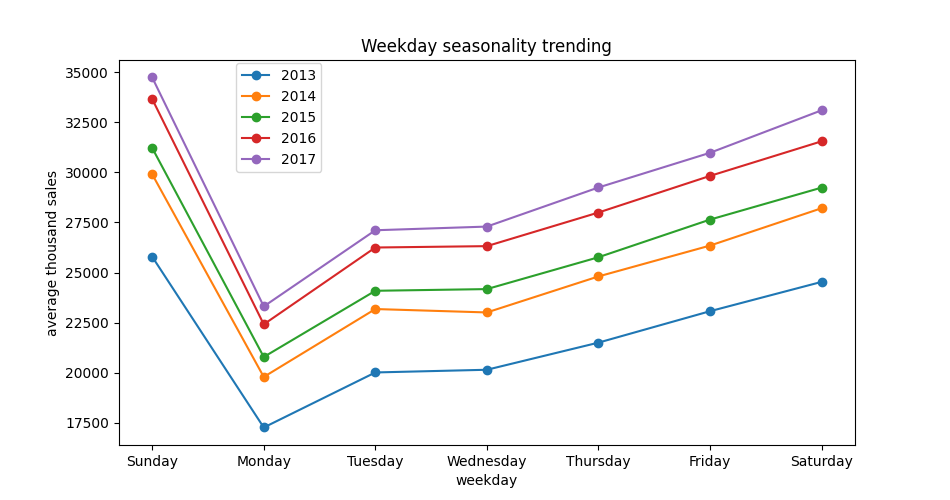

In [25]:
#weekday seasonality trending in each year
#libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import datetime

df_plotting = df_weekday_seasonality_trending.copy() #stop cause error when editing on same df
#df_plotting['month'] = pd.to_datetime(df_plotting['month'])
df_plotting.set_index('weekday', inplace=True)

pt_df_plotting = pd.pivot_table(df_plotting,
                    index=df_plotting.index,
                    columns=df_plotting.year, sort=False)
pt_df_plotting.columns = pt_df_plotting.columns.droplevel() # remove the double header (0) as pivot creates a multiindex.

#sorting Indext to start with sunday and end in Saturday
pt_df_plotting = pd.concat([pt_df_plotting.loc[['Sunday']], pt_df_plotting.loc['Monday': 'Saturday']], axis=0)

ax = plt.figure(figsize=(9.5,5)).add_subplot()
ax.plot(pt_df_plotting, marker='o')
ax.set_xlabel("weekday")
ax.set_ylabel('average thousand sales')

ax.set_title('Weekday seasonality trending')
#ax.xaxis("New")
ax.legend(pt_df_plotting.columns.tolist(), loc='center left', bbox_to_anchor=(0.15, .85)) #add the column names as legend.

plt.show()

The basic weekday pattern with our data is an increasing consumption start on Monday, peak at Sunday and dropping at Monday again. We can predict on this trending for weekday consumption

### Build a Forecast
We will start to build a single forecast with FBProphet

In [26]:
%%sparksql
SELECT CAST(date as date) as ds, store, item, sales as y
FROM train
WHERE store=1 AND item=1
ORDER BY ds;

only showing top 20 row(s)


ds,store,item,y
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
2013-01-06,1,1,12
2013-01-07,1,1,10
2013-01-08,1,1,9
2013-01-09,1,1,12
2013-01-10,1,1,9


In [27]:
#query to collect data
query_1store_forecast = """
SELECT CAST(date as date) as ds, sales as y
FROM train
WHERE store=1 AND item=1
ORDER BY ds;
"""
#assemble dataset in pandas df
df_1store_forecast = spark.sql(query_1store_forecast).toPandas()

#drop any missing records
df_1store_forecast = df_1store_forecast.dropna()

In [28]:
df_1store_forecast.head(5)

,ds,y
0,2013-01-01,13
1,2013-01-02,11
2,2013-01-03,14
3,2013-01-04,13
4,2013-01-05,10


In [29]:
df_1store_forecast.describe()

,y
count,1826.000000
mean,19.971522
std,6.741022
min,4.000000
25%,15.000000
50%,19.000000
75%,24.000000
max,50.000000


We now will import fbprophet library, and tune the logging setting

In [30]:
from fbprophet import Prophet
import logging

#disable information messages from fbprophet
logging.getLogger('py4j').setLevel(logging.ERROR)

We will set overall growth param to linear base on trending EDA above and enable the evaluation of weekly and uearly seasonal patterns. We might also wish to set our seasonality mode to multiplicative as the seasonal pattern seems to grow with overall growth is sales

In [31]:
#set model params
model = Prophet(
    interval_width=0.95,
    growth='linear',
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True,
    seasonality_mode='multiplicative'
)
#fit the model to historical data
model.fit(df_1store_forecast)

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -18.4541
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      91       3520.62   0.000177102       75.5416   2.713e-06       0.001      169  LS failed, Hessian reset 
      99       3520.64   8.62856e-05       50.4909      0.9699      0.9699      178   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     195       3520.68   5.06209e-05       54.5957   8.201e-07       0.001      346  LS failed, Hessian reset 
     199       3520.68   3.78129e-06       38.3929      0.3618           1      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     239       3520.68    6.8478e-06       73.2674   9.599e-08       0.001      455  LS failed, Hessian reset 
     260       3520.68   1.22061e-07       44.9099     0.07806      0.2692      483   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

We completed the trained model, lets use it for 90-day forrecast on first single store

In [32]:
#we define dataset, include historical dates with 90 day forecast
datedt_hist_fure = model.make_future_dataframe(
            periods=90,
            freq='d',
            include_history=True
)
df_forecast_hist_fure = model.predict(datedt_hist_fure)

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [33]:
datedt_hist_fure.head(5)

,ds
0,2013-01-01
1,2013-01-02
2,2013-01-03
3,2013-01-04
4,2013-01-05


In [34]:
df_forecast_hist_fure.head(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2013-01-01,15.601853,1.293232,18.575585,15.601853,15.601853,-0.356005,-0.356005,-0.356005,-0.088832,-0.088832,-0.088832,-0.267173,-0.267173,-0.267173,0.0,0.0,0.0,10.047511
1,2013-01-02,15.607552,2.384032,18.296593,15.607552,15.607552,-0.325667,-0.325667,-0.325667,-0.059022,-0.059022,-0.059022,-0.266645,-0.266645,-0.266645,0.0,0.0,0.0,10.524681
2,2013-01-03,15.613250,2.400554,19.976758,15.613250,15.613250,-0.292319,-0.292319,-0.292319,-0.025389,-0.025389,-0.025389,-0.266929,-0.266929,-0.266929,0.0,0.0,0.0,11.049203
3,2013-01-04,15.618948,3.297483,21.127445,15.618948,15.618948,-0.216325,-0.216325,-0.216325,0.051662,0.051662,0.051662,-0.267986,-0.267986,-0.267986,0.0,0.0,0.0,12.240186
4,2013-01-05,15.624646,5.547624,21.811796,15.624646,15.624646,-0.118330,-0.118330,-0.118330,0.151423,0.151423,0.151423,-0.269752,-0.269752,-0.269752,0.0,0.0,0.0,13.775785


<IPython.core.display.Javascript object>


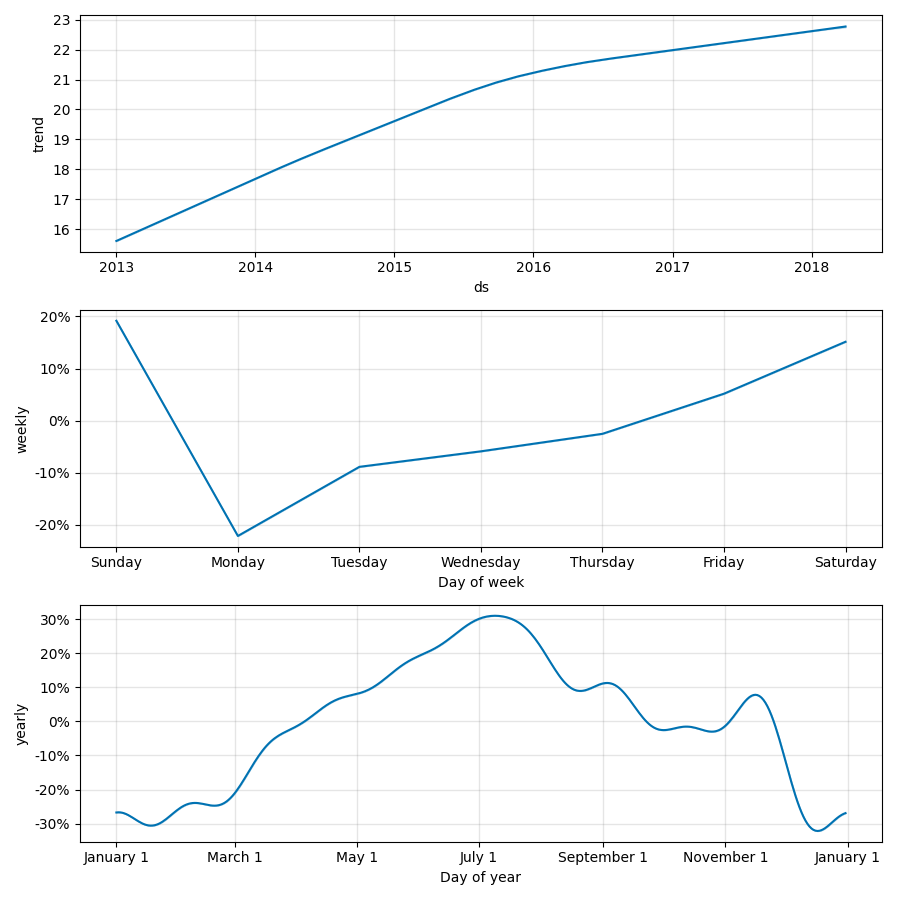

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


<IPython.core.display.Javascript object>


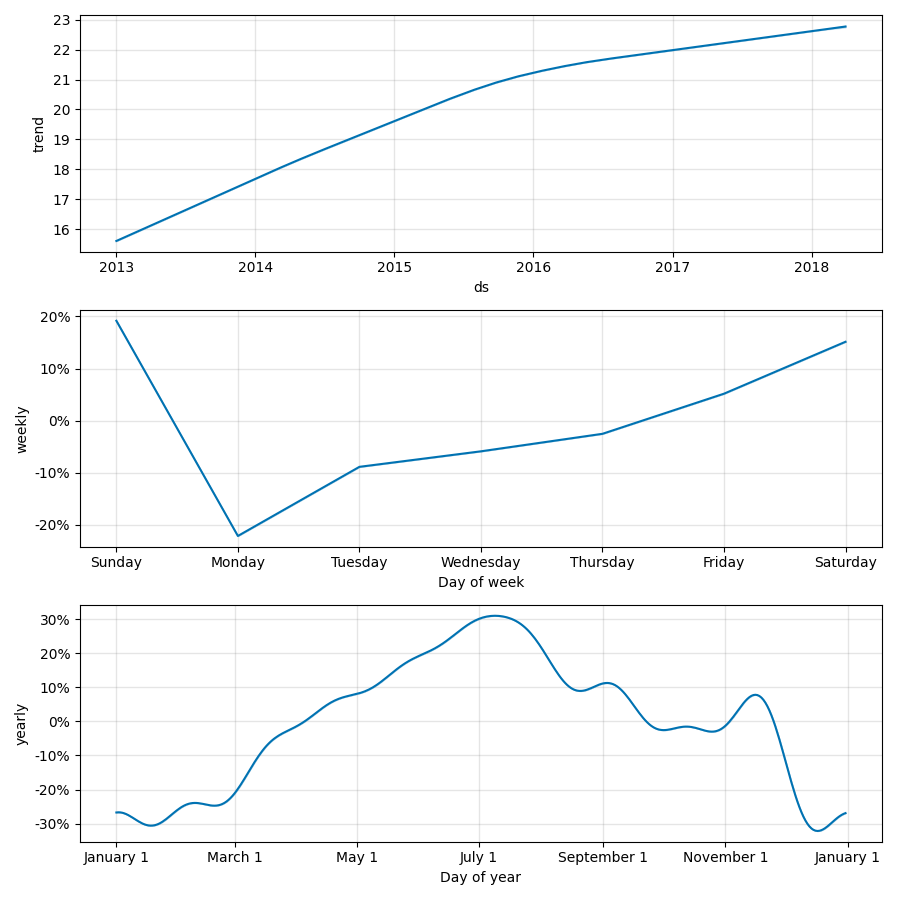

In [35]:
trends_fig = model.plot_components(df_forecast_hist_fure)
display(trends_fig)

#### Evaluate our model using Visualize function with model

We now will see how our actual and predicted data line ip as well as a forecast

<IPython.core.display.Javascript object>


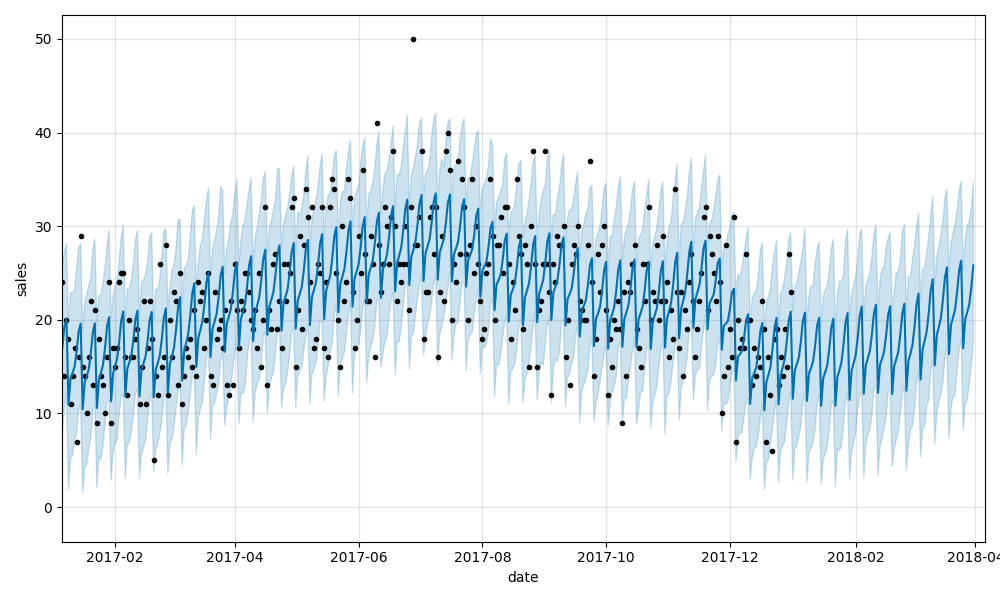

(17171.75, 17626.75)

In [36]:
predict_fig = model.plot(df_forecast_hist_fure, xlabel='date', ylabel='sales')

#adjust figure to display dates from last year and the 90 day forecast
xlim = predict_fig.axes[0].get_xlim()
new_xlim = (xlim[1]-(180.0+365.0), xlim[1]-90.0)
predict_fig.axes[0].set_xlim(new_xlim)

The black dot represents our actual data, and the blue line represents our predicted data, the light blue band represents our (95%) uncertainty interval.

#### Evaluate model with MAE, MSE, RMSE

In [37]:
pd.to_datetime("2018-1-1")

Timestamp('2018-01-01 00:00:00')

In [38]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from datetime import date

#get historical actuals & predictions for comparison pandas.to_datetime(data['date'])
df_actuals_data = df_1store_forecast[df_1store_forecast['ds'] < pd.Timestamp(2018, 1, 1)]['y']
df_predicted_data = df_forecast_hist_fure[df_forecast_hist_fure['ds'] < pd.Timestamp(2018, 1, 1)]['yhat']

#calculate evaluation metrics
mae = mean_absolute_error(df_actuals_data, df_predicted_data)
mse = mean_squared_error(df_actuals_data, df_predicted_data)
rmse = sqrt(mse)

# print metrics to the screen
print( '\n'.join(['MAE: {0}', 'MSE: {1}', 'RMSE: {2}']).format(mae, mse, rmse))

MAE: 3.486559544351376
MSE: 19.388724195449495
RMSE: 4.403262903285414


/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


#### Evaluate using Cross Validation

selecting cutoff points in the history, and for each of them fitting the model using data only up to that cutoff point. We can then compare the forecasted values to the actual values.

In [39]:
#import cross validation from Fprophet with argument below
from fbprophet.diagnostics import cross_validation
#initial = size of train dataset, with 3 years training data over our 5 year dataset
#horizon = size to be forecasted, 90 days forecast
#period = spacing between cutoff dates as incremental, ussually halft of horizon, every 45 days
df_cv_1store = cross_validation(model, initial='1065 days', period='90 days', horizon='90 days')

INFO:fbprophet:Making 8 forecasts with cutoffs between 2016-01-11 00:00:00 and 2017-10-02 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -38.9843
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      78       2008.98    0.00244692       225.475   2.488e-05       0.001      139  LS failed, Hessian reset 
      99       2009.37    0.00075262       103.278           1           1      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     141       2009.75    0.00093734       118.134    8.53e-06       0.001      252  LS failed, Hessian reset 
     199       2009.88   3.76455e-08       73.0542      0.4279      0.4279      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200       2009.88   9.64422e-08       75.5755      0.2502      0.9723      330   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -34.5697
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2171.41     0.0019014       109.044           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       2171.48   0.000877861       193.637   6.988e-06       0.001      173  LS failed, Hessian reset 
     144       2171.56   1.27432e-07       79.9575      0.9987      0.9987      226   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -30.4947
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2330.59   0.000323547       73.6446           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     186        2330.8   4.88559e-08       73.3982      0.1391      0.3819      240   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -20.6005
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      47       2483.01   0.000587018       132.921   7.821e-06       0.001       97  LS failed, Hessian reset 
      99       2483.12   1.96013e-05       66.2417      0.1461      0.1461      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2483.19   1.92818e-06       72.4362      0.3665           1      294   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       2483.19   2.93632e-07       63.3186           1           1      314   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -32.4723
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      48       2636.57   0.000531578       137.194   6.335e-06       0.001      100  LS failed, Hessian reset 
      99       2637.93   6.49005e-05       66.5798      0.2271      0.2271      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     148       2637.97   0.000118004       64.6162   1.639e-06       0.001      275  LS failed, Hessian reset 
     199       2637.99   1.30691e-06       78.1567      0.6571      0.6571      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     224       2637.99   1.51067e-07       49.1456      0.4021           1      391   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -20.9799
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2795.73   0.000197381        71.909           1           1      143   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       2795.74   4.52574e-05       59.5545   9.688e-07       0.001      191  LS failed, Hessian reset 
     170       2795.75   1.39887e-06       58.6551   1.929e-08       0.001      325  LS failed, Hessian reset 
     173       2795.75   8.14903e-08       42.8055      0.2796           1      329   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -16.2942
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59       3182.81   0.000127177       60.9675   1.626e-06       0.001      121  LS failed, Hessian reset 
      99       3182.82   3.51971e-06       68.6667      0.3257      0.3257      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     159       3182.86    0.00034871       72.2608   4.077e-06       0.001      306  LS failed, Hessian reset 
     199       3182.87   3.02924e-06        59.284      0.2905           1      366   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     226       3182.87    7.3804e-08       54.4584      0.3878           1      402   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -37.773
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3348.36    0.00193591       115.746           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       3348.69   0.000300732       124.091   2.373e-06       0.001      172  LS failed, Hessian reset 
     199       3348.83   8.83893e-06       65.9066           1           1      297   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       3348.84   1.80101e-05       72.0647   2.626e-07       0.001      354  LS failed, Hessian reset 
     265       3348.84   2.14818e-07       65.2525           1           1      427   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [40]:
df_cv_1store

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2016-01-12,13.311458,4.711828,21.576094,13,2016-01-11
1,2016-01-13,14.059992,5.825464,22.707013,9,2016-01-11
2,2016-01-14,14.596205,6.507080,23.340566,18,2016-01-11
3,2016-01-15,16.644040,8.656864,24.963540,13,2016-01-11
4,2016-01-16,18.693441,10.020426,27.310478,8,2016-01-11
...,...,...,...,...,...,...
715,2017-12-27,15.126029,6.502976,23.752933,14,2017-10-02
716,2017-12-28,15.866180,6.789345,23.857777,19,2017-10-02
717,2017-12-29,17.928795,9.058130,26.490312,15,2017-10-02
718,2017-12-30,20.006505,11.457105,28.799356,27,2017-10-02


In [41]:
#The performance_metrics utility can be used to compute some useful statistics of the prediction performance
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv_1store)

In [42]:
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,9 days,23.776680,4.876134,3.950937,0.240754,0.182064,0.916667
1,10 days,25.421274,5.041951,4.140523,0.249355,0.190529,0.902778
2,11 days,24.271269,4.926588,4.014951,0.235866,0.182064,0.916667
3,12 days,25.254048,5.025341,4.134820,0.241933,0.182064,0.916667
4,13 days,25.046085,5.004606,4.090799,0.238181,0.176959,0.902778
...,...,...,...,...,...,...,...
77,86 days,30.344874,5.508618,3.994245,0.220303,0.133149,0.902778
78,87 days,31.509442,5.613327,4.134688,0.215644,0.142674,0.888889
79,88 days,31.647479,5.625609,4.225199,0.218916,0.154451,0.888889
80,89 days,31.151110,5.581318,4.173489,0.211319,0.149953,0.902778


<IPython.core.display.Javascript object>


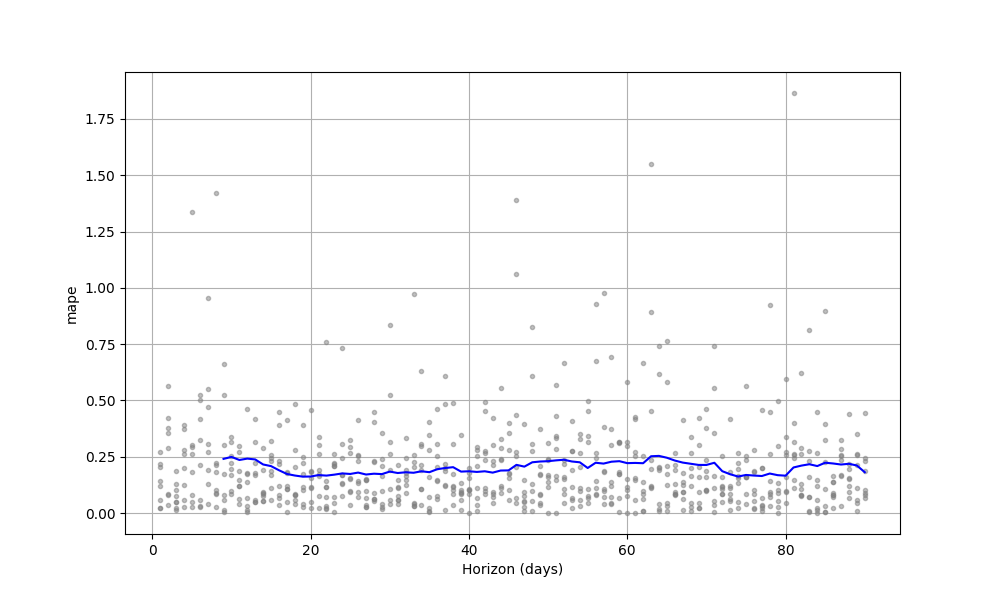

In [43]:
##visualized with plot_cross_validation_metric
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv_1store, metric='mape')

### Scaling Model Training & Forecasting
Now we going to build numberous, fine-grain models and forecast for indivual store and item combinations

In [44]:
##sql to collect data from database
sql_all_store_items = """
                    SELECT store, item, DATE(date) as ds, SUM(sales) as y
                    FROM train
                    GROUP BY store, item, ds
                    ORDER BY store, item, ds
                    """

spsql_store_item_history = (
    spark.sql(sql_all_store_items).repartition(sc.defaultParallelism, ['store', 'item'])).cache()

In [45]:
spsql_store_item_history.show(1000)

+-----+----+----------+---+
|store|item|        ds|  y|
+-----+----+----------+---+
|    7|  16|2016-10-17| 20|
|    7|  16|2017-12-13| 13|
|    7|  16|2014-08-18| 13|
|    7|  16|2015-01-06|  7|
|    7|  16|2016-06-22| 18|
|    7|  16|2013-01-18| 11|
|    7|  16|2014-09-02| 15|
|    7|  16|2016-12-29| 13|
|    7|  16|2015-02-25| 15|
|    7|  16|2015-07-04| 18|
|    7|  16|2016-05-06| 22|
|    7|  16|2016-12-23| 20|
|    7|  16|2017-07-14| 35|
|    7|  16|2014-10-11| 16|
|    7|  16|2014-02-27| 10|
|    7|  16|2013-12-20| 17|
|    7|  16|2016-12-10| 18|
|    7|  16|2017-03-13|  8|
|    7|  16|2014-01-27|  7|
|    7|  16|2013-05-23| 19|
|    7|  16|2013-08-11| 15|
|    7|  16|2014-07-24| 27|
|    7|  16|2015-03-30| 16|
|    7|  16|2016-02-28| 14|
|    7|  16|2013-05-24| 17|
|    7|  16|2014-07-15| 17|
|    7|  16|2017-01-18| 15|
|    7|  16|2017-03-15| 14|
|    7|  16|2013-12-08| 11|
|    7|  16|2015-04-12| 24|
|    7|  16|2016-08-30| 27|
|    7|  16|2017-01-12| 12|
|    7|  16|2013-01-

Our goal is to build a model for each store and item combination, so we will need to pass in a store-item subset from the dataset we assembled, train a model on that subset, and receive a store-item forecast back. We'd expect that forecast to be returned as a datset with a structure like this where we retrain the store and item identifiers for which the forecast was assembled and we limit the output ot just the relevant subset of fields generated by the Prophet model:

In [46]:
from pyspark.sql.types import *

#create schema for the forecast output returned
result_schema = StructType([
    StructField('ds', DateType()),
    StructField('store', IntegerType()),
    StructField('item', IntegerType()),
    StructField('y', FloatType()),
    StructField('yhat', FloatType()),
    StructField('yhat_upper', FloatType()),
    StructField('yhat_lower', FloatType())
])

Using Pandas user-defined function (UDF) to train the model and generate a forecast. We will define this function to receive a subset of data organized around a store and item combination. It will return a forecast in the format identified in the schema structure we created above

In [47]:
from pyspark.sql.functions import pandas_udf, PandasUDFType

@pandas_udf(result_schema, PandasUDFType.GROUPED_MAP)
def forecast_store_item(history_pd):
    #TRAIN MODEL
    # -------------------------
    #remove missing values
    history_pd = history_pd.dropna()
    
    # configure the model
    model = Prophet(
        interval_width=0.95,
        growth='linear',
        daily_seasonality=False,
        weekly_seasonality=True,
        yearly_seasonality=True,
        seasonality_mode='multiplicative'
    )
    
    #train the model
    model.fit(history_pd)
    #--------------------
    
    #BUILD FORECAST
    #--------------------
    #make predictions
    furture_pd = model.make_future_dataframe(
        periods=90,
        fred='d',
        include_history=True
    )
    
    forecast_pd = model.predict(furture_pd)
    #--------------------
    
    #ASSEMBLE EXPECTED RESULT SET
    #--------------------
    # get relevant fields from forecast
    f_pd = forecast_pd[['ds', 'yhat', 'yhat_upper', 'yhat_lower']].set_index('ds')
    
    #get relevant fields from history
    h_pd = history_pd[['ds', 'store', 'item', 'y']].set_index('ds')
    
    #Join history and forecast
    results_pd = f_pd.join(h_pd, how='left')
    results_pd.reset_index(level=0, inplace=True)
    
    #get store & item from incoming data set
    results_pd['store'] = history_pd['store'].iloc[0]
    results_pd['item'] = history_pd['item'].iloc[0]
    #-------------------
    
    #return expected dataset
    return results_pd[['ds', 'store', 'item', 'y', 'yhat', 'yhat_upper', 'yhat_lower']]

call our UDF to build our forecasts. we do this by grouping our historical dataset around store and item. We then apply our UDF to each group and tack on today's date as our training_date for data management purposes

In [48]:
spsql_store_item_history.show(5)

+-----+----+----------+---+
|store|item|        ds|  y|
+-----+----+----------+---+
|    7|  16|2016-10-17| 20|
|    7|  16|2017-12-13| 13|
|    7|  16|2014-08-18| 13|
|    7|  16|2015-01-06|  7|
|    7|  16|2016-06-22| 18|
+-----+----+----------+---+
only showing top 5 rows



In [49]:
from pyspark.sql.functions import current_date

#Group data on store and item level, then use function forecast to forecast on thi store and item level
results = (
    spsql_store_item_history.groupBy('store',
        'item').apply(forecast_store_item).withColumn('training_date', current_date())
)

results.createOrReplaceTempView('new_forecasts')

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/pyspark/sql/pandas/group_ops.py:98: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


save our results to a queriable table structure

In [60]:
pyspark --packages io.delta:delta-core_2.12:1.0.0 --conf "spark.sql.extensions=io.delta.sql.DeltaSparkSessionExtension" --conf "spark.sql.catalog.spark_catalog=org.apache.spark.sql.delta.catalog.DeltaCatalog"

SyntaxError: invalid syntax (1381631706.py, line 1)

In [58]:
%%sparksql
create table if not exists forecasts (
  date date,
  store integer,
  item integer,
  sales float,
  sales_predicted float,
  sales_predicted_upper float,
  sales_predicted_lower float,
  training_date date
  )
using delta
partitioned by (training_date);

Py4JJavaError: An error occurred while calling o30.sql.
: java.lang.ClassNotFoundException: 
Failed to find data source: delta. Please find packages at
https://spark.apache.org/third-party-projects.html
       
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedToFindDataSourceError(QueryExecutionErrors.scala:574)
	at org.apache.spark.sql.execution.datasources.DataSource$.lookupDataSource(DataSource.scala:675)
	at org.apache.spark.sql.execution.datasources.DataSource$.lookupDataSourceV2(DataSource.scala:725)
	at org.apache.spark.sql.catalyst.analysis.ResolveSessionCatalog.org$apache$spark$sql$catalyst$analysis$ResolveSessionCatalog$$isV2Provider(ResolveSessionCatalog.scala:602)
	at org.apache.spark.sql.catalyst.analysis.ResolveSessionCatalog$$anonfun$apply$1.applyOrElse(ResolveSessionCatalog.scala:154)
	at org.apache.spark.sql.catalyst.analysis.ResolveSessionCatalog$$anonfun$apply$1.applyOrElse(ResolveSessionCatalog.scala:49)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.$anonfun$resolveOperatorsUpWithPruning$3(AnalysisHelper.scala:138)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(TreeNode.scala:176)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.$anonfun$resolveOperatorsUpWithPruning$1(AnalysisHelper.scala:138)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$.allowInvokingTransformsInAnalyzer(AnalysisHelper.scala:323)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsUpWithPruning(AnalysisHelper.scala:134)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsUpWithPruning$(AnalysisHelper.scala:130)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.resolveOperatorsUpWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsUp(AnalysisHelper.scala:111)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsUp$(AnalysisHelper.scala:110)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.resolveOperatorsUp(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.analysis.ResolveSessionCatalog.apply(ResolveSessionCatalog.scala:49)
	at org.apache.spark.sql.catalyst.analysis.ResolveSessionCatalog.apply(ResolveSessionCatalog.scala:43)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$2(RuleExecutor.scala:211)
	at scala.collection.LinearSeqOptimized.foldLeft(LinearSeqOptimized.scala:126)
	at scala.collection.LinearSeqOptimized.foldLeft$(LinearSeqOptimized.scala:122)
	at scala.collection.immutable.List.foldLeft(List.scala:91)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$1(RuleExecutor.scala:208)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$1$adapted(RuleExecutor.scala:200)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.execute(RuleExecutor.scala:200)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.org$apache$spark$sql$catalyst$analysis$Analyzer$$executeSameContext(Analyzer.scala:227)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.$anonfun$execute$1(Analyzer.scala:223)
	at org.apache.spark.sql.catalyst.analysis.AnalysisContext$.withNewAnalysisContext(Analyzer.scala:172)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.execute(Analyzer.scala:223)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.execute(Analyzer.scala:187)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$executeAndTrack$1(RuleExecutor.scala:179)
	at org.apache.spark.sql.catalyst.QueryPlanningTracker$.withTracker(QueryPlanningTracker.scala:88)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.executeAndTrack(RuleExecutor.scala:179)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.$anonfun$executeAndCheck$1(Analyzer.scala:208)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$.markInAnalyzer(AnalysisHelper.scala:330)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.executeAndCheck(Analyzer.scala:207)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$analyzed$1(QueryExecution.scala:76)
	at org.apache.spark.sql.catalyst.QueryPlanningTracker.measurePhase(QueryPlanningTracker.scala:111)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$executePhase$2(QueryExecution.scala:185)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:510)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$executePhase$1(QueryExecution.scala:185)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:779)
	at org.apache.spark.sql.execution.QueryExecution.executePhase(QueryExecution.scala:184)
	at org.apache.spark.sql.execution.QueryExecution.analyzed$lzycompute(QueryExecution.scala:76)
	at org.apache.spark.sql.execution.QueryExecution.analyzed(QueryExecution.scala:74)
	at org.apache.spark.sql.execution.QueryExecution.assertAnalyzed(QueryExecution.scala:66)
	at org.apache.spark.sql.Dataset$.$anonfun$ofRows$2(Dataset.scala:99)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:779)
	at org.apache.spark.sql.Dataset$.ofRows(Dataset.scala:97)
	at org.apache.spark.sql.SparkSession.$anonfun$sql$1(SparkSession.scala:622)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:779)
	at org.apache.spark.sql.SparkSession.sql(SparkSession.scala:617)
	at sun.reflect.GeneratedMethodAccessor132.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
Caused by: java.lang.ClassNotFoundException: delta.DefaultSource
	at java.net.URLClassLoader.findClass(URLClassLoader.java:387)
	at java.lang.ClassLoader.loadClass(ClassLoader.java:418)
	at java.lang.ClassLoader.loadClass(ClassLoader.java:351)
	at org.apache.spark.sql.execution.datasources.DataSource$.$anonfun$lookupDataSource$5(DataSource.scala:661)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.sql.execution.datasources.DataSource$.$anonfun$lookupDataSource$4(DataSource.scala:661)
	at scala.util.Failure.orElse(Try.scala:224)
	at org.apache.spark.sql.execution.datasources.DataSource$.lookupDataSource(DataSource.scala:661)
	... 62 more


In [50]:
%%sparksql
-- create forecast table
CREATE TABLE IF NOT EXISTS forecasts (
    date date,
    store integer,
    item integer,
    sales float,
    sales_predicted float,
    sales_predicted_upper float,
    sales_predicted_lower float,
    training_date date
)
USING delta
PARTITIONED BY (training_date);

-- load data to it
INSERT INTO forecasts
SELECT ds as date,
    store,
    store,
    item,
    y as sales,
    yhat as sales_predicted,
    yhat_upper as sales_predicted_upper,
    yhat_lower as sales_predicted_lower,
    training_date
FROM new_forecasts;

ParseException: 
Syntax error at or near 'INSERT': extra input 'INSERT'(line 16, pos 0)

== SQL ==
-- create forecast table
CREATE TABLE IF NOT EXISTS forecasts (
    date date,
    store integer,
    item integer,
    sales float,
    sales_predicted float,
    sales_predicted_upper float,
    sales_predicted_lower float,
    training_date date
)
USING delta
PARTITIONED BY (training_date);

-- load data to it
INSERT INTO forecasts
^^^
SELECT ds as date,
    store,
    store,
    item,
    y as sales,
    yhat as sales_predicted,
    yhat_upper as sales_predicted_upper,
    yhat_lower as sales_predicted_lower,
    training_date
FROM new_forecasts;
